# Clustering Crypto

In [24]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [25]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [26]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [27]:
# Alternatively, use the provided csv file:
from pathlib import Path
file_path = Path("crypto_data.csv")

crypto_df = pd.read_csv(file_path)
crypto_df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [28]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df.drop(columns='Unnamed: 0', inplace=True)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [29]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df.loc[crypto_df['IsTrading'] == True]
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [30]:
# Keep only cryptocurrencies with a working algorithm
array = ['PoW', 'PoW/PoS']
crypto_df = crypto_df.loc[crypto_df['ProofType'].isin(array)]
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [31]:
# Remove the "IsTrading" column
crypto_df.drop(columns = 'IsTrading', inplace=True)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
1,365Coin,X11,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,PoW,NaN,611000
4,808,SHA-256,PoW/PoS,0.000000e+00,0


In [32]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
4,808,SHA-256,PoW/PoS,0.000000e+00,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [33]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df.loc[crypto_df['TotalCoinsMined'] != 0]
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
8,Ethereum,Ethash,PoW,1.076842e+08,0


In [34]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = crypto_df[['CoinName']]

In [35]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns='CoinName', inplace=True)

In [36]:
# Create dummy variables for text features
dummy_crypto = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'], drop_first=True)

In [37]:
# Standardize data
scaler = StandardScaler()
scaler.fit(dummy_crypto)
dummy_scaled = scaler.transform(dummy_crypto)
dummy_scaled

array([[-0.21129146, -0.16014434, -0.04926646, ..., -0.08553989,
        -0.08553989,  1.16042704],
       [-0.14968272, -0.15111869, -0.04926646, ..., -0.08553989,
        -0.08553989,  1.16042704],
       [ 1.49823714,  5.1697257 , -0.04926646, ..., -0.08553989,
        -0.08553989,  1.16042704],
       ...,
       [-0.21041969, -0.15590296, -0.04926646, ..., -0.08553989,
        -0.08553989,  1.16042704],
       [-0.15405952, -0.13638886, -0.04926646, ..., -0.08553989,
        -0.08553989, -0.86175172],
       [-0.21086545, -0.15978806, -0.04926646, ..., -0.08553989,
        -0.08553989, -0.86175172]])

### Reducing Dimensions Using PCA

In [38]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(dummy_scaled)

In [39]:
# Create a DataFrame with the principal components data
crypto_pca_df = pd.DataFrame(data=crypto_pca, columns=['PC1', 'PC2', 'PC3'])
crypto_pca_df.head()

,PC1,PC2,PC3
0,-0.683179,1.247619,-1.108571
1,-0.646468,1.266946,-1.102408
2,3.098646,3.409268,2.573690
3,-0.001046,-1.272219,0.439619
4,0.358172,-2.014992,-0.230481


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [40]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km=KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca_df)
    inertia.append(km.inertia_)
elbow_data = {'k':k, 'inertia':inertia}
elbow_df = pd.DataFrame(elbow_data)
# Create the Elbow Curve using hvPlot
elbow_df.hvplot.line(x='k', y='inertia', xticks=k)

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [41]:
# Initialize the K-Means model
model = KMeans(n_clusters=5)
# Fit the model
model.fit(crypto_pca_df)
# Predict clusters
predictions=model.predict(crypto_pca_df)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
crypto_pca_df['class'] = model.labels_
crypto_pca_df.head()

,PC1,PC2,PC3,class
0,-0.683179,1.247619,-1.108571,1
1,-0.646468,1.266946,-1.102408,1
2,3.098646,3.409268,2.573690,4
3,-0.001046,-1.272219,0.439619,0
4,0.358172,-2.014992,-0.230481,0


### Visualizing Results

#### 3D-Scatter with Clusters

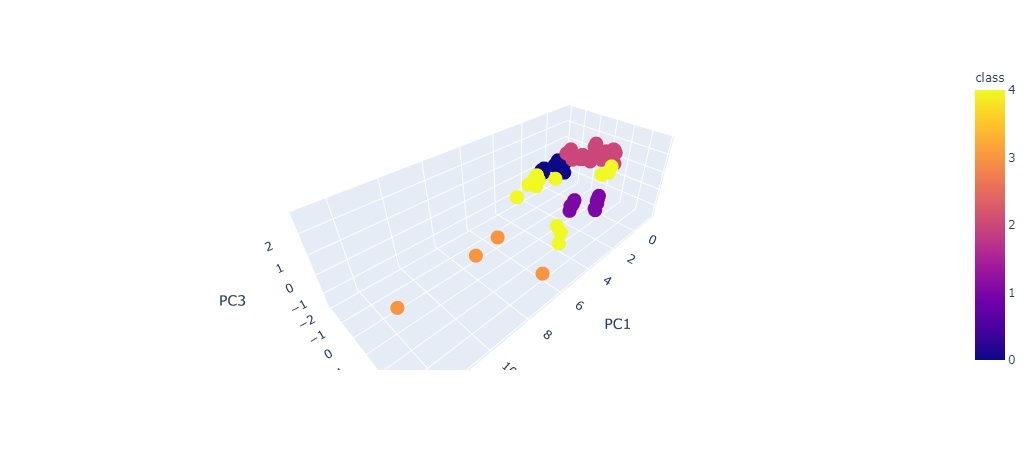

In [42]:
# Create a 3D-Scatter with the PCA data and the clusters
px.scatter_3d(crypto_pca_df, x='PC1', y='PC2', z='PC3', color='class')

#### Table of Tradable Cryptocurrencies

In [47]:
# Table with tradable cryptos
class_df = crypto_pca_df['class']
results_df = pd.concat([coin_name, crypto_df, class_df], join='inner', axis=1)
results_df.hvplot.table()

:Table   [CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,class]

In [53]:
# Print the total number of tradable cryptocurrencies
print(f"Total Number of Tradable cryptocurrencies: {len(results_df.CoinName)}")

Total Number of Tradable cryptocurrencies: 145


#### Scatter Plot with Tradable Cryptocurrencies

In [71]:
# Scale data to create the scatter plot
results_scaled = results_df.copy()
col_names = ['TotalCoinsMined', 'TotalCoinSupply']
features = test[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
results_scaled[col_names] = features
results_scaled

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,class
0,42 Coin,Scrypt,PoW/PoS,-0.194830,-0.192394,1
2,404Coin,Scrypt,PoW/PoS,-0.134847,-0.180480,4
5,EliteCoin,X13,PoW/PoS,1.469577,6.843170,1
7,Bitcoin,SHA-256,PoW,-0.193811,-0.191924,0
8,Ethereum,Ethash,PoW,-0.188708,-0.192394,0
9,Litecoin,Scrypt,PoW,-0.191246,-0.190513,0
10,Dash,X11,PoW/PoS,-0.194316,-0.191901,0
11,Monero,CryptoNight-V7,PoW,-0.193852,-0.192394,2
12,Ethereum Classic,Ethash,PoW,-0.188386,-0.187691,1
13,ZCash,Equihash,PoW,-0.194410,-0.191924,2


In [73]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
results_scaled.hvplot.scatter(x='TotalCoinsMined', y='TotalCoinSupply', hover_cols='CoinName',)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)